In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# échantillonneur de gibbs

def gibbs(theta_0, nb_it, X, sigma, alpha, beta):
    chaine_theta = np.empty((nb_it +1, 2))
    chaine_theta[0] = theta_0
    for l in range(nb_it):
        # Mise à jour sur mu
        mu_mean = (chaine_theta[l, 1]*np.sum(X)/
                                                (len(X)*chaine_theta[l,1] +1/sigma**2))
        mu_var =  1/(len(X)*chaine_theta[l,1] +1/sigma**2)

        chaine_theta[l+1, 0] = np.random.normal(mu_mean, np.sqrt(mu_var))

        # Mise à jour sur tau
        tau_shape = alpha + len(X)/2

        tau_rate = beta + np.sum((X - chaine_theta[l, 0])**2)/2

        chaine_theta[l+1, 1] = np.random.gamma(tau_shape, 1/tau_rate)

    return chaine_theta


In [3]:
# Génération des données

def gmm_rand(N, nb_clusters, pi, mu, tau):
    data = np.zeros((N))
    phi = np.zeros((N, nb_clusters))
    for i in range(N):
        phi[i, np.random.choice(nb_clusters)] = 1

        # on génére les données en fonction du cluster dans lequel est chaque individu

    for i in range(N):
            mult = np.random.multinomial(1, pi, size = 1)
            k = np.argmax(mult)
            data[i] = np.random.normal(mu[k],
                                            tau[k])
    return data

In [4]:
# Vraie densité
def gmm_pdf(pi, x, mu, tau):
        res = 0
        for k in range(len(pi)):
            res += norm.pdf(x, mu[k], tau[k])
        return res

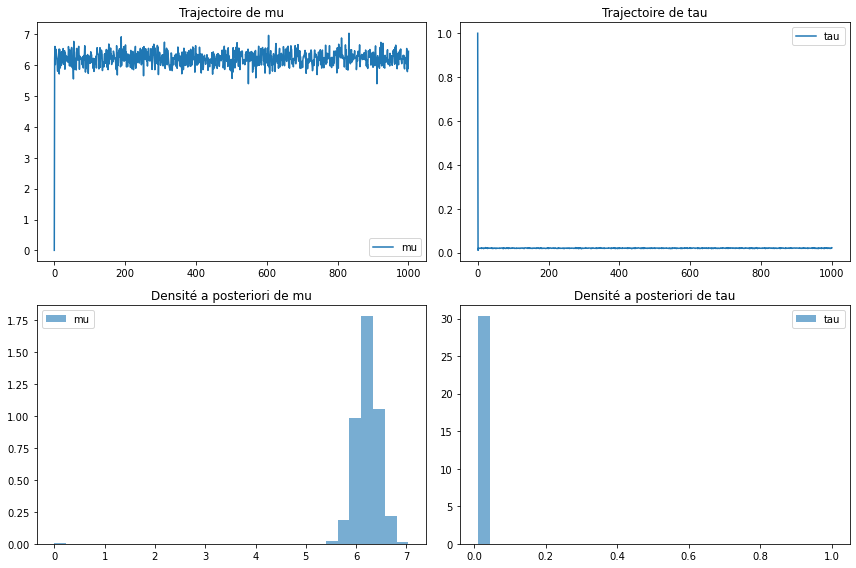

In [22]:
N = 1000
nb_clusters = 2
pi = [0.5 , 0.5]
sigma = 10
alpha = 2
beta = 1

mu_vraie = [np.random.normal(0, sigma)for k in range(nb_clusters)]
tau_vraie = [np.random.gamma(alpha, 1/beta) for k in range(nb_clusters)]

donnees = gmm_rand(N, 2, pi, mu_vraie, tau_vraie )

theta_0 = [0, 1]
nb_it = 1000


# Exécution de l'échantillonneur de Gibbs
chaine_theta = gibbs(theta_0, nb_it, donnees, sigma, alpha, beta)



# Affichage des résultats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Trajectoires des chaînes
axes[0, 0].plot(chaine_theta[:, 0], label="mu")
axes[0, 0].set_title("Trajectoire de mu")
axes[0, 0].legend()

axes[0, 1].plot(chaine_theta[:, 1], label="tau")
axes[0, 1].set_title("Trajectoire de tau")
axes[0, 1].legend()

# Densités a posteriori
axes[1, 0].hist(chaine_theta[:, 0], bins=30, density=True, alpha=0.6, label="mu")
axes[1, 0].set_title("Densité a posteriori de mu")
axes[1, 0].legend()


axes[1, 1].hist(chaine_theta[:, 1], bins=30, density=True, alpha=0.6, label="tau")
axes[1, 1].set_title("Densité a posteriori de tau")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def gmm_pdf(x, pi, mu, tau):
    res = 0
    for k in range(len(pi)):
        res += pi[k] * norm.pdf(x, mu[k], np.sqrt(1 / tau[k]))
    return res

# Affichage des données et de la densité
fig, ax = plt.subplots(1, 1)
xx = np.linspace(-20, 20, 1000)
ax.plot(xx, gmm_pdf(xx, pi, mu_true, tau_true), label="Densité vraie")
ax.hist(donnees, density=True, bins=30, alpha=0.6, label="Données générées")
ax.legend()
plt.show()